# Recurrent Neural Networks

In [9]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Time series forecasting

In [10]:
df = pd.read_csv('../data/cansim-0800020-eng-6674700030567901031.csv',
                 skiprows=6, skipfooter=9,
                 engine='python')
df.head()

,Adjustments,Unadjusted,Seasonally adjusted
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083


In [11]:
from pandas.tseries.offsets import MonthEnd

In [12]:
MonthEnd?

In [13]:
df['Adjustments'] = pd.to_datetime(df['Adjustments']) + MonthEnd(1)
df = df.set_index('Adjustments')
df.head()

,Unadjusted,Seasonally adjusted
Adjustments,,
1991-01-31,12588862,15026890
1991-02-28,12154321,15304585
1991-03-31,14337072,15413591
1991-04-30,15108570,15293409
1991-05-31,17225734,15676083


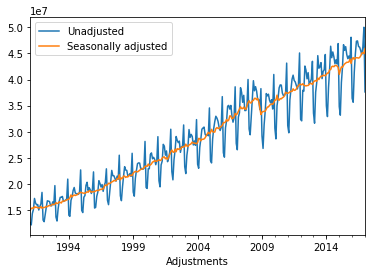

In [14]:
df.plot()

In [15]:
split_date = pd.Timestamp('01-01-2011')

In [16]:
train = df.loc[:split_date, ['Unadjusted']]
test = df.loc[split_date:, ['Unadjusted']]

In [17]:
train.head(3)

,Unadjusted
Adjustments,
1991-01-31,12588862
1991-02-28,12154321
1991-03-31,14337072


In [18]:
test.head(3)

,Unadjusted
Adjustments,
2011-01-31,31191594
2011-02-28,29797949
2011-03-31,36099866


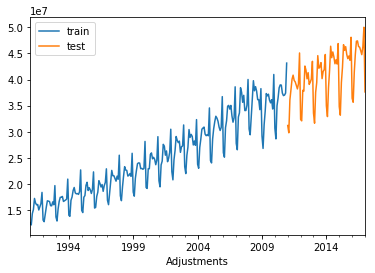

In [19]:
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [20]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [21]:
train_sc[:4]

array([[ 0.01402033],
       [ 0.        ],
       [ 0.0704258 ],
       [ 0.09531795]])

In [22]:
# See next cell for explanation
X_train = train_sc[:-1] # leave out the last one because we do not know what comes next to that since the training data has no next item and apparently the next item is the output
y_train = train_sc[1:]# leave out the first one because the next one (n+1) has to be the output for each n

X_test = test_sc[:-1]  # same here
y_test = test_sc[1:]  # same here

In [26]:
# Associating the next one as output for the current one.
for i, j in enumerate(zip(X_train, y_train)):
    print(i, j) if i < 5 else ''

0 (array([ 0.01402033]), array([ 0.]))
1 (array([ 0.]), array([ 0.0704258]))
2 (array([ 0.0704258]), array([ 0.09531795]))
3 (array([ 0.09531795]), array([ 0.16362761]))
4 (array([ 0.16362761]), array([ 0.13514108]))


### Fully connected predictor

In [39]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

In [40]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                24        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [41]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

In [42]:
model.fit(X_train, y_train, epochs=200,
          batch_size=2, verbose=1,
          callbacks=[early_stop])

Epoch 1/200
239/239 [==============================] - 1s 3ms/step - loss: 0.2188
Epoch 2/200
239/239 [==============================] - 0s 978us/step - loss: 0.0781
Epoch 3/200
239/239 [==============================] - 0s 1ms/step - loss: 0.0350
Epoch 4/200
239/239 [==============================] - 0s 1ms/step - loss: 0.0273
Epoch 5/200
239/239 [==============================] - 0s 1ms/step - loss: 0.0239
Epoch 6/200
239/239 [==============================] - 0s 1ms/step - loss: 0.0212
Epoch 7/200
239/239 [==============================] - 0s 1ms/step - loss: 0.0190
Epoch 8/200
239/239 [==============================] - 0s 1ms/step - loss: 0.0171
Epoch 9/200
239/239 [==============================] - 0s 1ms/step - loss: 0.0154
Epoch 10/200
239/239 [==============================] - 0s 1ms/step - loss: 0.0140
Epoch 11/200
239/239 [==============================] - 0s 1ms/step - loss: 0.0128
Epoch 12/200
239/239 [==============================] - 0s 1ms/step - loss: 0.0119
Epoch 13/20

In [43]:
y_pred = model.predict(X_test)

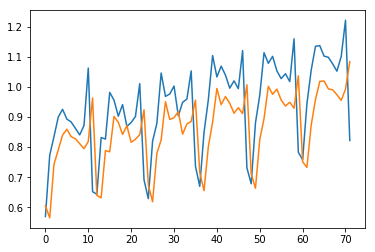

In [44]:
plt.plot(y_test)
plt.plot(y_pred)

### Recurrent predictor

In [45]:
from keras.layers import LSTM

In [46]:
X_train.shape

(239, 1)

In [47]:
#3D tensor with shape (batch_size, timesteps, input_dim)
X_train[:, None].shape

(239, 1, 1)

In [48]:
X_train_t = X_train[:, None]
X_test_t = X_test[:, None]

In [49]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 1)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [50]:
model.fit(X_train_t, y_train,
          epochs=100, batch_size=1, verbose=1,
          callbacks=[early_stop])

Epoch 1/100
239/239 [==============================] - 3s 13ms/step - loss: 0.1203
Epoch 2/100
239/239 [==============================] - 1s 4ms/step - loss: 0.0364
Epoch 3/100
239/239 [==============================] - 1s 4ms/step - loss: 0.0289A
Epoch 4/100
239/239 [==============================] - 1s 4ms/step - loss: 0.0226
Epoch 5/100
239/239 [==============================] - 1s 5ms/step - loss: 0.0176
Epoch 6/100
239/239 [==============================] - 1s 5ms/step - loss: 0.0141
Epoch 7/100
239/239 [==============================] - 1s 4ms/step - loss: 0.0121
Epoch 8/100
239/239 [==============================] - 1s 4ms/step - loss: 0.0110
Epoch 9/100
239/239 [==============================] - 1s 4ms/step - loss: 0.0106
Epoch 10/100
239/239 [==============================] - 1s 4ms/step - loss: 0.0104
Epoch 11/100
239/239 [==============================] - 1s 4ms/step - loss: 0.0105
Epoch 00011: early stopping


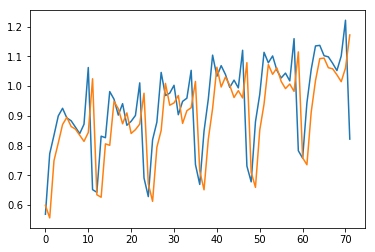

In [51]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

## Windows

In [52]:
train_sc.shape

(240, 1)

In [54]:
train.head(1)

,Unadjusted
Adjustments,
1991-01-31,12588862


In [55]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
train_sc_df.head()

,Scaled
Adjustments,
1991-01-31,0.014020
1991-02-28,0.000000
1991-03-31,0.070426
1991-04-30,0.095318
1991-05-31,0.163628


In [61]:
for s in range(1, 13):
    # Adding new cols to train_sc_df and initiating them using the shift function applied on the ['Scaled'] column
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

In [62]:
train_sc_df.head(13)

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,,
1991-01-31,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-02-28,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-03-31,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-04-30,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-05-31,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-06-30,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-07-31,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN
1991-08-31,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN
1991-09-30,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN


In [63]:
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

In [64]:
X_train.head()
# Note, I tried even after flipping the order of the shift sequence; the model still learns to perform just as well!

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,
1992-01-31,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020
1992-02-29,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000
1992-03-31,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426
1992-04-30,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318
1992-05-31,0.109831,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628


In [65]:
X_train.shape

(228, 12)

In [66]:
X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

In [69]:
X_train

array([[ 0.20091289,  0.13173822,  0.11139526, ...,  0.0704258 ,
         0.        ,  0.01402033],
       [ 0.03002688,  0.20091289,  0.13173822, ...,  0.09531795,
         0.0704258 ,  0.        ],
       [ 0.01999285,  0.03002688,  0.20091289, ...,  0.16362761,
         0.09531795,  0.0704258 ],
       ..., 
       [ 0.79916654,  0.81439355,  0.86398323, ...,  0.92972161,
         0.71629034,  0.77368724],
       [ 0.80210057,  0.79916654,  0.81439355, ...,  0.59734863,
         0.92972161,  0.71629034],
       [ 0.81482896,  0.80210057,  0.79916654, ...,  0.53166512,
         0.59734863,  0.92972161]])

In [78]:
np.fliplr(np.array([[1, 2, 3],
                    [4, 5, 6]]))

array([[3, 2, 1],
       [6, 5, 4]])

In [82]:
np.fliplr(np.array([[1, 2, 3],
                    [4, 5, 6]]))

array([[3, 2, 1],
       [6, 5, 4]])

### Fully Connected on Windows

In [83]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=12, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


In [84]:
model.fit(X_train, y_train, epochs=200,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/200
228/228 [==============================] - 1s 6ms/step - loss: 0.0206
Epoch 2/200
228/228 [==============================] - 1s 2ms/step - loss: 0.0129- ETA: 0s - los
Epoch 3/200
228/228 [==============================] - 1s 2ms/step - loss: 0.0089
Epoch 4/200
228/228 [==============================] - 1s 2ms/step - loss: 0.0073
Epoch 5/200
228/228 [==============================] - 1s 2ms/step - loss: 0.0063
Epoch 6/200
228/228 [==============================] - 1s 2ms/step - loss: 0.0052
Epoch 7/200
228/228 [==============================] - 1s 3ms/step - loss: 0.0046
Epoch 8/200
228/228 [==============================] - 1s 2ms/step - loss: 0.0038
Epoch 9/200
228/228 [==============================] - 1s 3ms/step - loss: 0.0033
Epoch 10/200
228/228 [==============================] - 1s 3ms/step - loss: 0.0030
Epoch 11/200
228/228 [==============================] - 1s 3ms/step - loss: 0.0028
Epoch 12/200
228/228 [==============================] - 1s 2ms/step - loss: 0.002

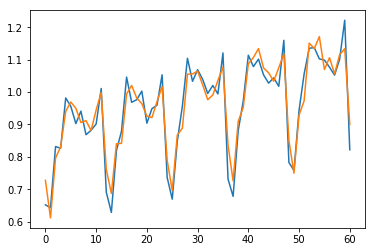

In [85]:
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)

### LSTM on Windows

In [87]:
X_train_t = X_train.reshape(X_train.shape[0], 1, 12)
X_test_t = X_test.reshape(X_test.shape[0], 1, 12)

In [88]:
#3D tensor with shape (batch_size, timesteps, input_dim)
X_train_t.shape

(228, 1, 12)

In [89]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 12)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [90]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6)                 456       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 463
Trainable params: 463
Non-trainable params: 0
_________________________________________________________________


In [91]:
model.fit(X_train_t, y_train, epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/100
228/228 [==============================] - 3s 14ms/step - loss: 0.0294
Epoch 2/100
228/228 [==============================] - 1s 4ms/step - loss: 0.0077
Epoch 3/100
228/228 [==============================] - 1s 5ms/step - loss: 0.0069
Epoch 4/100
228/228 [==============================] - 1s 6ms/step - loss: 0.0063
Epoch 5/100
228/228 [==============================] - 1s 7ms/step - loss: 0.0055
Epoch 6/100
228/228 [==============================] - 1s 5ms/step - loss: 0.0050
Epoch 7/100
228/228 [==============================] - 1s 5ms/step - loss: 0.0046
Epoch 8/100
228/228 [==============================] - 1s 6ms/step - loss: 0.0041
Epoch 9/100
228/228 [==============================] - 1s 6ms/step - loss: 0.0037
Epoch 10/100
228/228 [==============================] - 1s 6ms/step - loss: 0.0030
Epoch 11/100
228/228 [==============================] - 1s 6ms/step - loss: 0.0028
Epoch 12/100
228/228 [==============================] - 1s 6ms/step - loss: 0.0025
Epoch 13/100

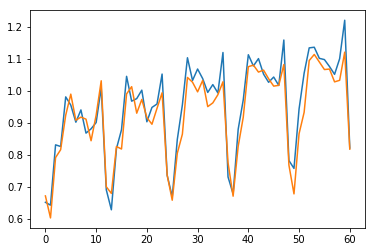

In [92]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

## Exercise 2

RNN models can be applied to images too. In general we can apply them to any data where there's a connnection between nearby units. Let's see how we can easily build a model that works with images.

- Load the MNIST data, by now you should be able to do it blindfolded :)
- reshape it so that an image looks like a long sequence of pixels
- create a recurrent model and train it on the training data
- how does it perform compared to a fully connected? How does it compare to Convolutional Neural Networks?

(feel free to run this exercise on a cloud GPU if it's too slow on your laptop)

## Exercise 1

In the model above we reshaped the input shape to: `(num_samples, 1, 12)`, i.e. we treated a window of 12 months as a vector of 12 coordinates that we simultaneously passed to all the LSTM nodes. An alternative way to look at the problem is to reshape the input to `(num_samples, 12, 1)`. This means we consider each input window as a sequence of 12 values that we will pass in sequence to the LSTM. In principle this looks like a more accurate description of our situation. But does it yield better predictions? Let's check it.

- Reshape `X_train` and `X_test` so that they represent a set of univariate sequences
- retrain the same LSTM(6) model, you'll have to adapt the `input_shape`
- check the performance of this new model, is it better at predicting the test data?